# Ban Luck - Using Reinforcement Learning to Squeeze your Relatives Dry

## What is Ban Luck?
In Southeast Asia (SEA), a Chinese New Year (CNY) tradition is to play Chinese Blackjack (Ban Luck) as a social activity. 

The game is as follows:

![How to Play?](assets/how_to_play.png "How to Play?")

**But you don't want to leave it down to luck, you want to "huat" (Be prosperous), so how do you squeeze every penny out of your relatives?**

## A typical strategy

### The Algorithm
As a player, what would be your strategy? Personally, I follow this algorithm:
```
Loop until Hold or Reveal:
  Let value = Hand value
  if value == 21 or value >= 17:
    Hold
  else:
    Draw
  if hand has 5 cards:
    Reveal
```

As a dealer, I would follow a similar algorithm but instead of holding, I would reveal hands.

Feels simple, and based on vibes, it seems sound!

### Benchmarking
But let's simulate some games with this algorithm and see how well it actually performs. 

For simplicity, 
- Everyone uses this algorithm in any given game unless otherwise stated.
- For all our runs unless otherwise stated, we will stick to 8 players (Including dealer).
- Be realistic, you will play at most 30 games every CNY. Despite that, our future measurements will be based on 1,000 games.

In [20]:
from players import SimplePlayer
from dealer import SimpleDealer
from game import Game, make_deck
from simulation import run_game
import numpy as np
import matplotlib.pyplot as plt
from deck import WashShuffleStrategy

N_PLAYERS = 8 # Includes dealer
SIMULATIONS = 1_000
# Exclude dealer
game = Game(n_players=N_PLAYERS - 1)

# rewards[i, j] is the reward for the j-th player in the i-th simulation
rewards = np.zeros((SIMULATIONS, N_PLAYERS))

deck = make_deck()
shuffle = WashShuffleStrategy()
for i in range(SIMULATIONS):
    shuffle.shuffle(deck) # Random shuffle
    # Simple is the strategy name for the algorithm we just described
    res = run_game(game, SimplePlayer(), SimpleDealer(), deck=deck)
    for j in range(N_PLAYERS):
        rewards[i, j] = res[j]
    game.soft_reset()


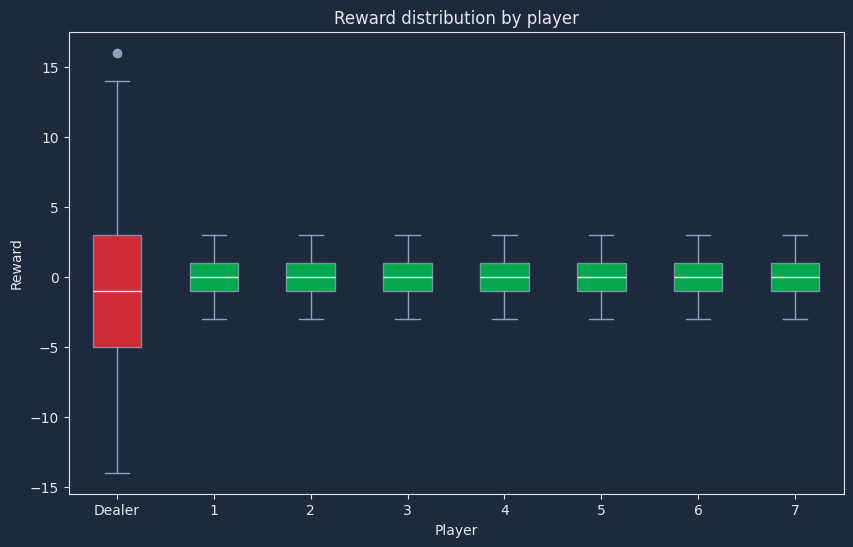

In [21]:
# Box plot: reward distribution for each player
COLOR_POSITIVE = "#00c950"
COLOR_NEGATIVE = "#fb2c36"
COLOR_PRIMARY = "#00bcff"
COLOR_SECONDARY = "#fe9a00"
BG = "#1d293d"
LABELS = "#e5e7eb"
BORDER = "#90a1b9"

# One column per player: rewards[:, j] = all simulation rewards for player j
data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()

Some observations:
- Position of the players (Excluding dealer) does not seem to matter
- Dealer seems to perform worse than players

But is that the case?

### Does Position Matter?
**TL;DR** There is no statistically detectable difference in rewards between seats. 

In [22]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# We will only analyze players (Excluding dealer)
data_by_player = [rewards[:, j] for j in range(1, N_PLAYERS)]
rows = []
for run in range(rewards.shape[0]):
    for player in range(1, N_PLAYERS):
        rows.append({"run": run, "player": player, "reward": rewards[run, player]})
df = pd.DataFrame(rows)

model = AnovaRM(data=df, depvar="reward", subject="run", within=["player"])
result = model.fit()
print("One-way repeated measures ANOVA: reward ~ player (subject = run)")
print(result.anova_table)

One-way repeated measures ANOVA: reward ~ player (subject = run)
         F Value  Num DF  Den DF    Pr > F
player  0.477826     6.0  5994.0  0.825317


Think of the `F Value` as how much `variability between rows (across players) / variability between columns (within a player) = 0.5578`, that is less variability between players than within players. There's a `76.4643%` chance of seeing this randomness purely by chance.

### Does being the Dealer matter?

**TL;DR** There is no signficant evidence to show that being the dealer is inherently disadvantageous. 

In [23]:
# Consolidate mean across all rows in data_by_player (one value per run for players)
# Compare with dealer's mean using paired t test
import numpy as np
from scipy import stats

dealer_rewards = rewards[:, 0]  # shape (SIMULATIONS,)
# Per run: mean reward of all non-dealer players (so we have one value per run to pair with dealer)
players_mean_per_run = np.mean(rewards[:, 1:], axis=1)  # shape (SIMULATIONS,)
t_stat, p_value = stats.ttest_rel(players_mean_per_run, dealer_rewards)
print("Paired t-test (dealer vs mean-of-players per run):")
print(f"  t = {t_stat:.4f}, p = {p_value:.4f}")
print(f"  Dealer mean = {np.mean(dealer_rewards):.4f}, Players (consolidated) mean = {np.mean(players_mean_per_run):.4f}")


Paired t-test (dealer vs mean-of-players per run):
  t = 3.4226, p = 0.0006
  Dealer mean = -0.6100, Players (consolidated) mean = 0.0871



### Does how you shuffle the deck matter?

**TL;DR** Shuffling MAY influence our strategy.

The deck is initially sorted (Ace, 2, 3, ..., K, Q, J), we obviously want to reduce *predictability* of cards so we first have to shuffle the deck.

Normally, the deck 
1. First goes through a **Wash Shuffle**, this usually very tedious to do so after each game
2. In subsequent rounds, the deck goes through a series of **Cut Shuffles**. Based on some rough observations, the Dealer then to do `~8`, each cutting `~30 to 70%` of the deck, in a single shuffle.

Instinctively, how we shuffle the deck should influence our strategy. If we do simple deck cutting, it feels that we can predict where cards are based on previous game localities due to ordering.

For simplicity, let's:
- Approximate a **Wash Shuffle** as a `random.shuffle` in Python.
- Assume `30 to 70%` each cut.
- Assume a **Wash Shuffle** is the "most random" strategy we can use when shuffling our deck 

How truly random is **Deck Cutting** really? Let's compare with **Wash Shuffle** by measuring the longest increasing sequence (LIS) of the shuffled deck.


In [24]:
import bisect
import numpy as np
import matplotlib.pyplot as plt
from game import make_deck
from deck import WashShuffleStrategy, DeckCuttingStrategy

N_SHUFFLES = 10_000
N_TO_TEST = 100

base_deck = make_deck()
card_to_index = {card: i for i, card in enumerate(base_deck)}

def deck_to_permutation(deck, card_to_index=card_to_index):
    return [card_to_index[c] for c in deck]

def lis_length(perm):
    tails = []
    for x in perm:
        i = bisect.bisect_left(tails, x)
        if i == len(tails):
            tails.append(x)
        else:
            tails[i] = x
    return len(tails)

wash = WashShuffleStrategy()
results = {}

vals = []
for _ in range(N_SHUFFLES):
    deck = make_deck()
    wash.shuffle(deck)
    vals.append(lis_length(deck_to_permutation(deck)))

results["Wash"] = vals

for n_cuts in range(1, N_TO_TEST + 1):
    strategy = DeckCuttingStrategy(
        n=n_cuts,
    )

    vals = []
    for _ in range(N_SHUFFLES):
        deck = make_deck()
        strategy.shuffle(deck)
        vals.append(lis_length(deck_to_permutation(deck)))

    results[f"Cut n={n_cuts}"] = vals


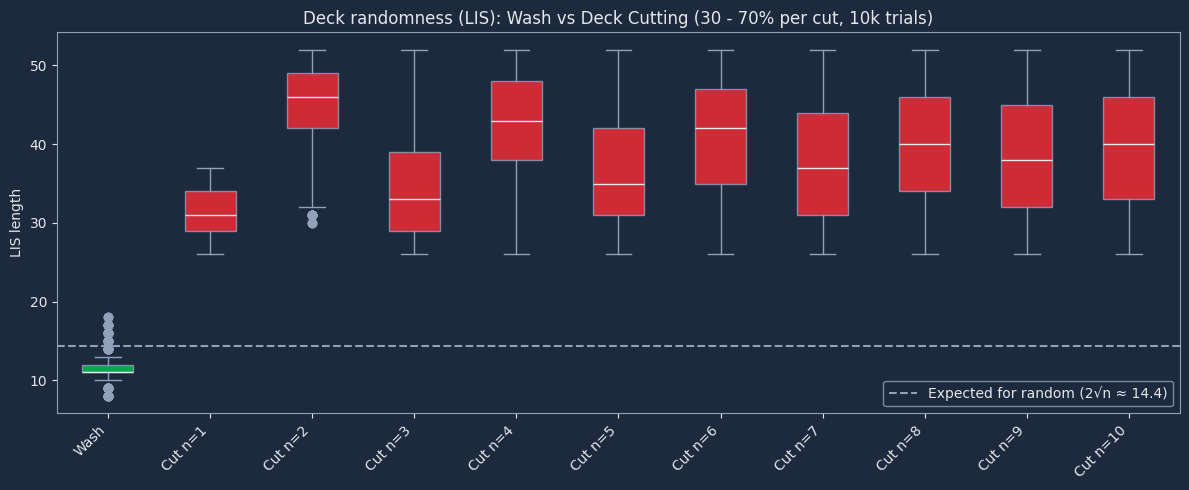

In [25]:
# Just plot the first 10
N_TO_PLOT = 10
labels = ["Wash"] + [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.median(results[label]) for label in labels]
# Green = more random (LIS closer to 2√n ≈ 14.4), red = more ordered
expected_random_lis = 2 * (52 ** 0.5)
# Green if LIS is close to 2√n ≈ 14.4, red if LIS is close to 1
box_colors = [COLOR_POSITIVE if m <= expected_random_lis else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)

bp = ax.boxplot(data_by_strategy, positions=np.arange(len(labels)), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right", color=LABELS)
ax.axhline(y=expected_random_lis, color=BORDER, linestyle="--", label=f"Expected for random (2√n ≈ {expected_random_lis:.1f})")
ax.set_ylabel("LIS length", color=LABELS)
ax.set_title("Deck randomness (LIS): Wash vs Deck Cutting (30 - 70% per cut, 10k trials)", color=LABELS)
ax.legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(BORDER)
plt.tight_layout()
plt.show()

The LIS is the largest set of cards that still appear in increasing relative order after the shuffle. Since a fresh deck starts fully sorted, a shorter LIS indicates that more of the original order has been destroyed, which implies greater randomness.

Some observations:
- There is a difference between **Wash Shuffle** and **Deck Cutting Shuffle**.
- Increasing the number of deck cuts, `n`, seems to converge.

Let's zoom out. If we plot the mean of deck cutting for each n, we see that it plateus.

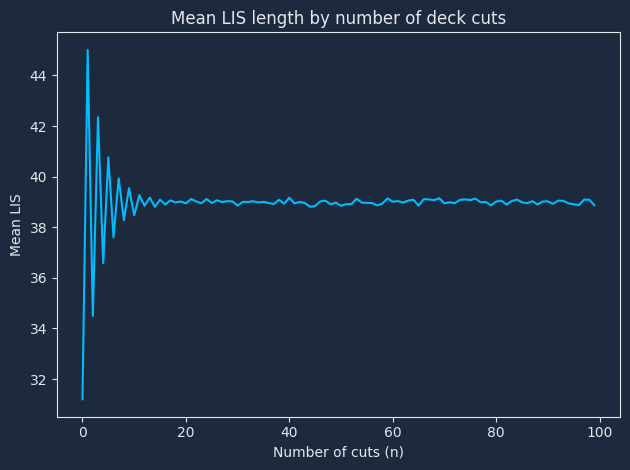

In [26]:
N_TO_PLOT = N_TO_TEST
labels = [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.mean(results[label]) for label in labels]

fig, ax = plt.subplots()
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
ax.plot(medians, color=COLOR_PRIMARY)
ax.set_title("Mean LIS length by number of deck cuts", color=LABELS)
ax.set_xlabel("Number of cuts (n)", color=LABELS)
ax.set_ylabel("Mean LIS", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.tight_layout()
plt.show()


We see that it converges to `~39`.

How does this compare to a **Wash Shuffle**? For simplicity, lets use the mean across all `n`.

In [27]:
# t-test: Deck Cutting vs Wash Shuffle
import numpy as np
from scipy import stats

# Wash vs Deck Cutting (pool all Cut n=1..10 into one group; use results from previous cell)
wash_lis = np.array(results["Wash"])
deck_cut_lis = np.concatenate([results[f"Cut n={k}"] for k in range(1, 11)])
t_stat, p_value = stats.ttest_ind(wash_lis, deck_cut_lis)
print("Independent-samples t-test (Wash vs Deck Cutting, LIS):")
print(f"  t = {t_stat:.4f}, p = {p_value:.4f}")
print(f"  Wash mean LIS = {np.mean(wash_lis):.4f}, Deck Cutting mean LIS = {np.mean(deck_cut_lis):.4f}")

Independent-samples t-test (Wash vs Deck Cutting, LIS):
  t = -354.1774, p = 0.0000
  Wash mean LIS = 11.5657, Deck Cutting mean LIS = 38.5777


We have a very high confidence that **Wash Shuffle** fundamentally produces different results than **Deck Cutting**.

But realistically, you would first do a wash then deck cutting. How would that fair?

In [28]:
N_SHUFFLES = 10_000
N_TO_TEST = 100


wash = WashShuffleStrategy()
results = {}

for n_cuts in range(1, N_TO_TEST + 1):
    strategy = DeckCuttingStrategy(
        n=n_cuts,
    )

    vals = []
    for _ in range(N_SHUFFLES):
        deck = make_deck()
        # We first do a wash shuffle
        wash.shuffle(deck)
        # Note: We are testing for predictability of deck cutting
        # We want to know the feasibility of players learning the deck over time
        # so we pit against the initial deck (i.e. the wash shuffled deck).
        card_to_index = {card: i for i, card in enumerate(deck)}
        # Then we do a deck cutting shuffle
        strategy.shuffle(deck)
        vals.append(lis_length(deck_to_permutation(deck, card_to_index)))

    results[f"Cut n={n_cuts}"] = vals

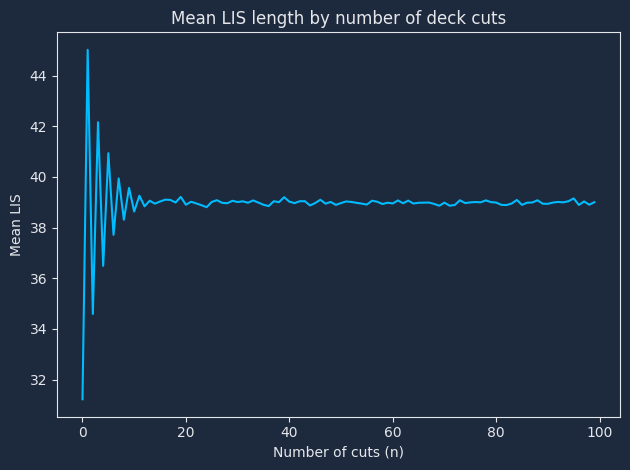

In [32]:
N_TO_PLOT = N_TO_TEST
labels = [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.mean(results[label]) for label in labels]

fig, ax = plt.subplots()
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
ax.plot(medians, color=COLOR_PRIMARY)
ax.set_title("Mean LIS length by number of deck cuts", color=LABELS)
ax.set_xlabel("Number of cuts (n)", color=LABELS)
ax.set_ylabel("Mean LIS", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.tight_layout()
plt.show()

In [30]:
from agent import mc_control, policy_to_dict
import json

num_episodes = 1_000_000
epsilon = 0.1

print("Training Player agent (Monte Carlo control)...")
print(f"  n_players={N_PLAYERS}, agent_position=1, num_episodes={num_episodes}, epsilon={epsilon}")
Q, policy = mc_control(
    n_players=N_PLAYERS,
    agent_position=1,
    num_episodes=num_episodes,
    epsilon=epsilon,
    first_shuffle_strategy=WashShuffleStrategy(),
    subsequent_shuffle_strategy=DeckCuttingStrategy(),
)

policy_path = "policy.json"
policy = dict(sorted(policy.items(), key=lambda x: (len(x[0]), x[0])))
data = policy_to_dict(policy)
with open(policy_path, "w") as f:
    json.dump(data, f, indent=2)

Training Player agent (Monte Carlo control)...
  n_players=8, agent_position=1, num_episodes=1000000, epsilon=0.1
Episode 0 of 1000000 (0.0%)
Episode 100000 of 1000000 (10.0%)
Episode 200000 of 1000000 (20.0%)
Episode 300000 of 1000000 (30.0%)
Episode 400000 of 1000000 (40.0%)
Episode 500000 of 1000000 (50.0%)
Episode 600000 of 1000000 (60.0%)
Episode 700000 of 1000000 (70.0%)
Episode 800000 of 1000000 (80.0%)
Episode 900000 of 1000000 (90.0%)


Benchmark: 10000 games, 8 players (including dealer)

PolicyBasedPlayer (trained):
  Mean reward (per player): 0.0536
  Std dev:                  0.7457

SimplePlayer:
  Mean reward (per player): 0.0424
  Std dev:                  0.7964

--- Significance (paired) ---
  Mean difference (Policy − Simple): 0.0112
  95% CI: [-0.0102, 0.0326]
  Paired t-test: t = 1.0284, p = 0.3038


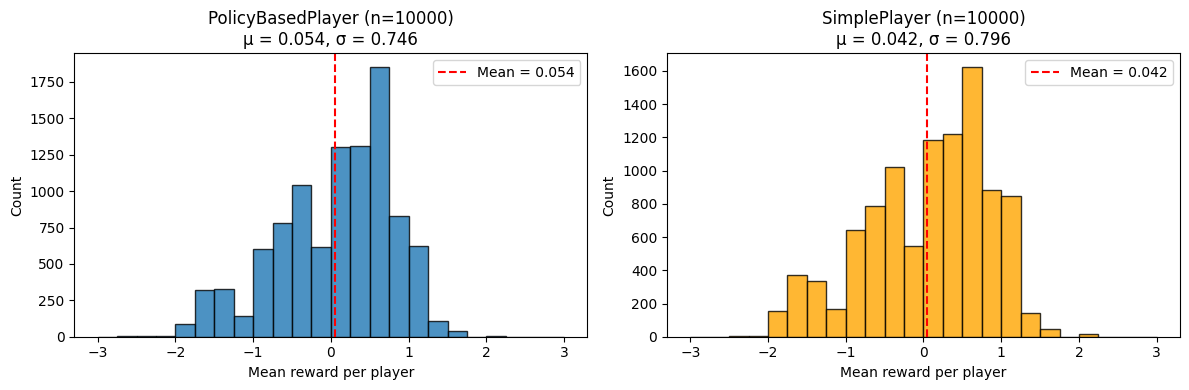

In [31]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from game import Game, make_deck
from simulation import run_game
from players import SimplePlayer, PolicyBasedPlayer
from dealer import SimpleDealer
from agent import policy_from_dict
from deck import WashShuffleStrategy, DeckCuttingStrategy

BENCHMARK_RUNS = 10_000
policy_path = Path("policy.json")
if not policy_path.exists():
    raise FileNotFoundError(f"Policy not found: {policy_path}. Run the training cell above first.")

with open(policy_path) as f:
    policy = policy_from_dict(json.load(f))

policy_player = PolicyBasedPlayer(policy, epsilon=0.0)
simple_player = SimplePlayer()
dealer = SimpleDealer()
bench_game = Game(n_players=N_PLAYERS - 1)
wash_shuffle = WashShuffleStrategy()
deck_cutting = DeckCuttingStrategy()
deck = make_deck()

rewards_policy_runs = np.zeros(BENCHMARK_RUNS)
rewards_simple_runs = np.zeros(BENCHMARK_RUNS)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_p = run_game(bench_game, policy_player, dealer, cur_deck)
    rewards_policy_runs[run] = np.mean(res_p[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_s = run_game(bench_game, simple_player, dealer, cur_deck)
    rewards_simple_runs[run] = np.mean(res_s[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)

mean_policy = np.mean(rewards_policy_runs)
mean_simple = np.mean(rewards_simple_runs)
std_policy = np.std(rewards_policy_runs, ddof=1)
std_simple = np.std(rewards_simple_runs, ddof=1)

print(f"Benchmark: {BENCHMARK_RUNS} games, {N_PLAYERS} players (including dealer)\n")
print("PolicyBasedPlayer (trained):")
print(f"  Mean reward (per player): {mean_policy:.4f}")
print(f"  Std dev:                  {std_policy:.4f}")
print("\nSimplePlayer:")
print(f"  Mean reward (per player): {mean_simple:.4f}")
print(f"  Std dev:                  {std_simple:.4f}")

mean_diff = mean_policy - mean_simple
if BENCHMARK_RUNS >= 2:
    t_stat, p_value = stats.ttest_rel(rewards_policy_runs, rewards_simple_runs)
    diffs = rewards_policy_runs - rewards_simple_runs
    std_diff = np.std(diffs, ddof=1)
    se_diff = std_diff / np.sqrt(BENCHMARK_RUNS)
    t_95 = 1.96 if BENCHMARK_RUNS > 30 else {2: 4.30, 5: 2.57, 10: 2.23, 20: 2.09, 30: 2.04}.get(BENCHMARK_RUNS, 2.0)
    ci_lo, ci_hi = mean_diff - t_95 * se_diff, mean_diff + t_95 * se_diff
    print("\n--- Significance (paired) ---")
    print(f"  Mean difference (Policy − Simple): {mean_diff:.4f}")
    print(f"  95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")
    print(f"  Paired t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# Histograms for both strategies
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bin_edges = np.arange(-3, 3.25, 0.25)
axes[0].hist(rewards_policy_runs, bins=bin_edges, edgecolor="black", alpha=0.8)
axes[0].axvline(mean_policy, color="red", linestyle="--", label=f"Mean = {mean_policy:.3f}")
axes[0].set_xlabel("Mean reward per player")
axes[0].set_ylabel("Count")
axes[0].set_title(f"PolicyBasedPlayer (n={BENCHMARK_RUNS})\nμ = {mean_policy:.3f}, σ = {std_policy:.3f}")
axes[0].legend()

axes[1].hist(rewards_simple_runs, bins=bin_edges, edgecolor="black", alpha=0.8, color="orange")
axes[1].axvline(mean_simple, color="red", linestyle="--", label=f"Mean = {mean_simple:.3f}")
axes[1].set_xlabel("Mean reward per player")
axes[1].set_ylabel("Count")
axes[1].set_title(f"SimplePlayer (n={BENCHMARK_RUNS})\nμ = {mean_simple:.3f}, σ = {std_simple:.3f}")
axes[1].legend()
plt.tight_layout()
plt.show()

## Conclusion
So how to huat at ban luck? No real strategy, **JUST BE lUCKY!**.

## The Real Point of this Post
Over the past 2 years, I have been approached by 20+ students asking for advice on their projects, **I absolutely love it!**

Often, I get asked **What should I be using?**. This was my mindset, I have worked on over 100+ projects, but not until last year, I did not manage to ship anything. I realised the demotivation stems from not finding the **right meaning** for myself.